## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [60]:
%env CUDA_VISIBLE_DEVICES=1
#%env

env: CUDA_VISIBLE_DEVICES=1


In [61]:
import inflect
import matplotlib
# %matplotlib inline
import matplotlib.pylab as plt
# matplotlib.use("Agg")

import IPython.display as ipd

import sys
sys.path.append('/home/ubuntu/tacotron2-nvidia/')
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
#from denoiser import Denoiser

# use 2nd GPU for jupyter

In [62]:
#torch.cuda.set_device(0)
#print(torch.cuda.current_device())

In [63]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [65]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [66]:
#checkpoint_path = "models/tacotron2_statedict.pt"
# checkpoint_path = "models_ocw.0.2/checkpoint_9000"
checkpoint_path = "models_ocw.0.2_noignore/checkpoint_1000"

model = load_model(hparams)

#### Load WaveGlow for mel2audio synthesis and denoiser

In [75]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

for p in model.decoder.parameters():
    print(p.requires_grad)



28193153
28193153
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [55]:
waveglow_path = 'models/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
#denoiser = Denoiser(waveglow)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. 

#### Prepare text input

In [56]:
# text = "6.345 WOOHOO!"
# text = "CRISPR Cas9"
# text = "tracrRNA WTF"
text = "flavin adenine dinucleotide"
text = "redox active co enzyme"



# xt = "reedox active co enzyme"
# xt = "piridoxameene"
#text = "pyridoxamine is a flavin adenine dinucleotide"
#text = "chemistry has a straightforward lexicon"
# text = "We find that 100% of antibiotic-resistant V. cholerae receiving the plasmid are killed. Escape mutants were extremely rare (10−6–10−8). We show that conjugation and specific killing of targeted bacteria occurs in the microbiota of zebrafish and crustacean larvae"
# text = "I also want to give you the nomenclature for the isoalloxazine ring"
# text = "nicotinamide adenine dinucleotide"
text = "when you play the game of thrones. you win, or you cry"

# text = "this is a test sentence"

#text = "tracrRNA"

# text = "RNA

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()


#### Decode text input and plot results

Warning! Reached max decoder steps


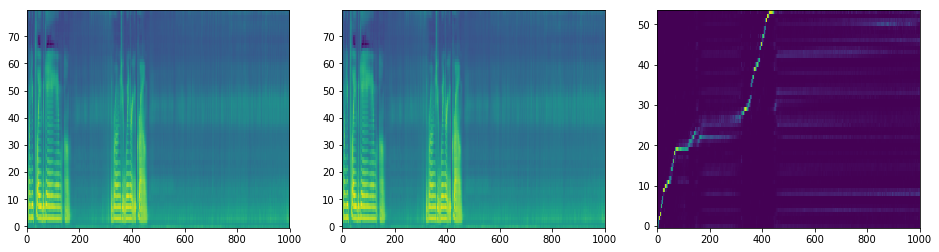

In [57]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using Griffin Lim

In [58]:
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet.double())
# print(mel_outputs_postnet.type())
# print(mel_decompress.type())
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis.double())
# spec_from_mel = np.matmul(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling
spec_from_mel = spec_from_mel.float()
#print(spec_from_mel.type())
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)
ipd.Audio(waveform, rate=hparams.sampling_rate)

#### Synthesize audio from spectrogram using WaveGlow

In [59]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/module.py:489: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  result = self.forward(*input, **kwargs)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/module.py:489: RuntimeWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  result = self.forward(*input, **kwargs)


#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 